# Seq2Seq RNN Code Generation - Reproducible Analytics

**Purpose**: Load trained models and generate comprehensive performance analysis and visualizations

**Workflow**: 
1. Load trained models from `models/` directory
2. Load tokenizers and configuration
3. Reconstruct test dataset
4. Evaluate all three models
5. Generate visualizations and metrics report

**Note**: Run `rnn-seq2seq.ipynb` on Google Colab first, then download the `models/` directory

In [28]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import json
import pickle
import re
from tqdm.auto import tqdm
from collections import Counter, defaultdict
import warnings
import sacrebleu
from heapq import heappush, heappop

warnings.filterwarnings('ignore')

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported and configured")

Device: cpu
✓ Libraries imported and configured


## 1. Load Configuration and Tokenizers

In [29]:
class Tokenizer:
    """Simple whitespace-based tokenizer (same as in training notebook)"""
    def __init__(self, vocab_size=5000):
        self.vocab_size = vocab_size
        self.word2idx = {}
        self.idx2word = {}
        self.vocab_built = False
    
    def tokenize(self, text):
        text = text.lower()
        text = re.sub(r'([\(\)\[\]\{\}:,\.=\+\-\*\/])', r' \1 ', text)
        tokens = text.split()
        return tokens
    
    def decode(self, indices, skip_special_tokens=True):
        tokens = []
        for idx in indices:
            if idx in self.idx2word:
                token = self.idx2word[idx]
                if skip_special_tokens and token in ['<PAD>', '<SOS>', '<EOS>', '<UNK>']:
                    if token == '<EOS>':
                        break
                    continue
                tokens.append(token)
        return ' '.join(tokens)
    
    @classmethod
    def load(cls, filepath):
        with open(filepath, 'r') as f:
            data = json.load(f)
        
        tokenizer = cls(vocab_size=data['vocab_size'])
        tokenizer.word2idx = data['word2idx']
        tokenizer.idx2word = {int(k): v for k, v in data['idx2word'].items()}
        tokenizer.vocab_built = True
        return tokenizer

# Load configuration
with open('models/config.json', 'r') as f:
    CONFIG = json.load(f)

print("Configuration loaded:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

# Load tokenizers
src_tokenizer = Tokenizer.load('models/src_tokenizer.json')
tgt_tokenizer = Tokenizer.load('models/tgt_tokenizer.json')

print(f"\n✓ Tokenizers loaded")
print(f"  Source vocabulary size: {len(src_tokenizer.word2idx)}")
print(f"  Target vocabulary size: {len(tgt_tokenizer.word2idx)}")

# Load training history
with open('models/training_history.pkl', 'rb') as f:
    training_history = pickle.load(f)

print(f"✓ Training history loaded")

Configuration loaded:
  TRAIN_SIZE: 10000
  VAL_SIZE: 1500
  TEST_SIZE: 1500
  MAX_DOCSTRING_LEN: 50
  MAX_CODE_LEN: 80
  EMBEDDING_DIM: 256
  HIDDEN_DIM: 256
  NUM_LAYERS: 2
  DROPOUT: 0.3
  BIDIRECTIONAL: True
  BATCH_SIZE: 64
  EPOCHS: 20
  LEARNING_RATE: 0.001
  TEACHER_FORCING_RATIO: 0.5
  VOCAB_SIZE: 5000
  GRADIENT_CLIP: 1.0
  WARMUP_STEPS: 1000
  EARLY_STOPPING_PATIENCE: 3
  BEAM_SIZE: 3
  SCHEDULED_SAMPLING: True

✓ Tokenizers loaded
  Source vocabulary size: 5000
  Target vocabulary size: 5000
✓ Training history loaded


## 2. Define Models Architecture

In [30]:
class BiLSTMEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=2, dropout=0.3, bidirectional=True):
        super(BiLSTMEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, 
                           dropout=dropout if num_layers > 1 else 0, bidirectional=bidirectional)
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional
        self.num_layers = num_layers
    
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        outputs, (hidden, cell) = self.lstm(embedded)
        
        if self.bidirectional:
            num_layers = self.num_layers
            batch_size = hidden.shape[1]
            hidden_dim = hidden.shape[2]
            
            hidden_reshaped = hidden.view(num_layers, 2, batch_size, hidden_dim)
            cell_reshaped = cell.view(num_layers, 2, batch_size, hidden_dim)
            
            hidden = ((hidden_reshaped[-1, 0] + hidden_reshaped[-1, 1]) / 2).unsqueeze(0).contiguous()
            cell = ((cell_reshaped[-1, 0] + cell_reshaped[-1, 1]) / 2).unsqueeze(0).contiguous()
        
        return outputs, hidden, cell

## 3. Load Trained Models

In [31]:
src_vocab_size = len(src_tokenizer.word2idx)
tgt_vocab_size = len(tgt_tokenizer.word2idx)

print("Loading trained models...\n")

# Vanilla RNN
rnn_encoder = VanillaRNNEncoder(src_vocab_size, CONFIG['EMBEDDING_DIM'], CONFIG['HIDDEN_DIM'],
                               dropout=CONFIG['DROPOUT'], bidirectional=CONFIG['BIDIRECTIONAL'])
rnn_decoder = VanillaRNNDecoder(tgt_vocab_size, CONFIG['EMBEDDING_DIM'], CONFIG['HIDDEN_DIM'],
                               dropout=CONFIG['DROPOUT'])
rnn_model = VanillaRNNSeq2Seq(rnn_encoder, rnn_decoder, device).to(device)

checkpoint = torch.load('models/vanilla_rnn_best.pt', map_location=device)
rnn_model.load_state_dict(checkpoint['model_state_dict'], strict=False)
rnn_model.eval()
print(f"✓ Vanilla RNN loaded (Epoch {checkpoint['epoch']+1}, Loss: {checkpoint['loss']:.4f})")

# LSTM
lstm_encoder = LSTMEncoder(src_vocab_size, CONFIG['EMBEDDING_DIM'], CONFIG['HIDDEN_DIM'],
                          num_layers=CONFIG['NUM_LAYERS'], dropout=CONFIG['DROPOUT'],
                          bidirectional=CONFIG['BIDIRECTIONAL'])
lstm_decoder = LSTMDecoder(tgt_vocab_size, CONFIG['EMBEDDING_DIM'], CONFIG['HIDDEN_DIM'],
                          num_layers=CONFIG['NUM_LAYERS'], dropout=CONFIG['DROPOUT'])
lstm_model = LSTMSeq2Seq(lstm_encoder, lstm_decoder, device).to(device)

checkpoint = torch.load('models/lstm_best.pt', map_location=device)
lstm_model.load_state_dict(checkpoint['model_state_dict'], strict=False)
lstm_model.eval()
print(f"✓ LSTM loaded (Epoch {checkpoint['epoch']+1}, Loss: {checkpoint['loss']:.4f})")

# LSTM with Attention
encoder_output_dim = CONFIG['HIDDEN_DIM'] * 2 if CONFIG['BIDIRECTIONAL'] else CONFIG['HIDDEN_DIM']
attn_encoder = BiLSTMEncoder(src_vocab_size, CONFIG['EMBEDDING_DIM'], CONFIG['HIDDEN_DIM'],
                            num_layers=CONFIG['NUM_LAYERS'], dropout=CONFIG['DROPOUT'],
                            bidirectional=CONFIG['BIDIRECTIONAL'])
attn_decoder = AttentionDecoder(tgt_vocab_size, CONFIG['EMBEDDING_DIM'], CONFIG['HIDDEN_DIM'],
                               encoder_output_dim=encoder_output_dim)
attn_model = LSTMAttentionSeq2Seq(attn_encoder, attn_decoder, device).to(device)

checkpoint = torch.load('models/lstm_attention_best.pt', map_location=device)
attn_model.load_state_dict(checkpoint['model_state_dict'], strict=False)
attn_model.eval()
print(f"✓ LSTM with Attention loaded (Epoch {checkpoint['epoch']+1}, Loss: {checkpoint['loss']:.4f})")

Loading trained models...

✓ Vanilla RNN loaded (Epoch 16, Loss: 4.9318)
✓ LSTM loaded (Epoch 1, Loss: 4.8566)
✓ LSTM with Attention loaded (Epoch 1, Loss: 4.9570)


## 4. Define Evaluation Functions

In [32]:
def greedy_decode(model, src, max_len, device, use_attention=False):
    """Greedy decoding: select highest probability token at each step"""
    model.eval()
    src = src.to(device)
    
    with torch.no_grad():
        # Encode
        if hasattr(model.encoder, 'lstm'):
            if isinstance(model, LSTMAttentionSeq2Seq):
                encoder_outputs, hidden, cell = model.encoder(src)
            else:
                encoder_outputs, hidden, cell = model.encoder(src)
                
                # Handle bidirectional encoder output for LSTM
                if model.encoder.bidirectional:
                    num_layers = model.encoder.num_layers
                    batch_size = hidden.shape[1]
                    hidden_dim = hidden.shape[2]
                    
                    hidden_reshaped = hidden.view(num_layers, 2, batch_size, hidden_dim)
                    cell_reshaped = cell.view(num_layers, 2, batch_size, hidden_dim)
                    
                    hidden = (hidden_reshaped[:, 0] + hidden_reshaped[:, 1]).contiguous() / 2
                    cell = (cell_reshaped[:, 0] + cell_reshaped[:, 1]).contiguous() / 2
        else:
            encoder_outputs, hidden = model.encoder(src)
            cell = None
            
            # Handle bidirectional encoder output for Vanilla RNN
            if hasattr(model.encoder, 'bidirectional') and model.encoder.bidirectional:
                hidden_fwd = hidden[0].unsqueeze(0)
                hidden_bwd = hidden[1].unsqueeze(0)
                hidden = ((hidden_fwd + hidden_bwd) / 2).contiguous()
        
        # Decode
        decoder_input = torch.tensor([[1]], device=device)  # <SOS>
        decoded = [1]
        attentions = []
        
        for _ in range(max_len):
            if use_attention:
                prediction, hidden, cell, attn_weights = model.decoder(decoder_input, hidden, cell, encoder_outputs)
                attentions.append(attn_weights.cpu().numpy())
            elif cell is not None:
                prediction, hidden, cell = model.decoder(decoder_input, hidden, cell)
            else:
                prediction, hidden = model.decoder(decoder_input, hidden)
            
            top1 = prediction.argmax(1).item()
            decoded.append(top1)
            
            if top1 == 2:  # <EOS>
                break
            
            decoder_input = torch.tensor([[top1]], device=device)
    
    if use_attention and attentions:
        return decoded, np.array(attentions)
    return decoded, None

def calculate_metrics(model, docstrings, codes_text, max_len, use_attention=False):
    """Calculate token accuracy, exact match, and return predictions"""
    all_predictions = []
    all_references = []
    token_correct = 0
    token_total = 0
    exact_matches = 0
    
    for docstring, code_text in tqdm(zip(docstrings, codes_text), total=len(docstrings), desc="Evaluating"):
        # Encode docstring
        src_indices = src_tokenizer.tokenize(docstring.lower())
        src_indices = [src_tokenizer.word2idx.get(t, src_tokenizer.word2idx.get('<UNK>', 3))
                      for t in src_indices[:CONFIG['MAX_DOCSTRING_LEN']-2]]
        src_indices = [1] + src_indices + [2]
        src_tensor = torch.tensor([src_indices], device=device)
        
        # Decode
        decoded, _ = greedy_decode(model, src_tensor, max_len, device, use_attention)
        
        # Convert to text
        pred_text = tgt_tokenizer.decode(decoded, skip_special_tokens=True)
        ref_text = code_text.lower()
        
        all_predictions.append(pred_text)
        all_references.append(ref_text)
        
        # Token accuracy
        pred_tokens = pred_text.split()
        ref_tokens = ref_text.split()
        if len(ref_tokens) > 0:
            min_len = min(len(pred_tokens), len(ref_tokens))
            token_correct += sum(1 for j in range(min_len) if pred_tokens[j] == ref_tokens[j])
            token_total += len(ref_tokens)
        
        # Exact match
        if pred_text.strip() == ref_text.strip():
            exact_matches += 1
    
    token_accuracy = (token_correct / token_total * 100) if token_total > 0 else 0
    exact_match_accuracy = (exact_matches / len(docstrings) * 100) if len(docstrings) > 0 else 0
    
    return {
        'token_accuracy': token_accuracy,
        'exact_match': exact_match_accuracy,
        'predictions': all_predictions,
        'references': all_references
    }

print("✓ Evaluation functions defined")

✓ Evaluation functions defined


In [33]:

def beam_search_decode(model, src, max_len, beam_size, device, use_attention=False):
    """Beam search decoding with beam_size hypotheses"""
    model.eval()
    src = src.to(device)
    
    with torch.no_grad():
        # Encode
        if hasattr(model.encoder, 'lstm'):
            if isinstance(model, LSTMAttentionSeq2Seq):
                encoder_outputs, hidden, cell = model.encoder(src)
            else:
                encoder_outputs, hidden, cell = model.encoder(src)
                
                # Handle bidirectional encoder output for LSTM
                if model.encoder.bidirectional:
                    num_layers = model.encoder.num_layers
                    batch_size = hidden.shape[1]
                    hidden_dim = hidden.shape[2]
                    
                    hidden_reshaped = hidden.view(num_layers, 2, batch_size, hidden_dim)
                    cell_reshaped = cell.view(num_layers, 2, batch_size, hidden_dim)
                    
                    hidden = (hidden_reshaped[:, 0] + hidden_reshaped[:, 1]).contiguous() / 2
                    cell = (cell_reshaped[:, 0] + cell_reshaped[:, 1]).contiguous() / 2
        else:
            encoder_outputs, hidden = model.encoder(src)
            cell = None
            
            # Handle bidirectional encoder output for Vanilla RNN
            if hasattr(model.encoder, 'bidirectional') and model.encoder.bidirectional:
                hidden_fwd = hidden[0].unsqueeze(0)
                hidden_bwd = hidden[1].unsqueeze(0)
                hidden = ((hidden_fwd + hidden_bwd) / 2).contiguous()
        
        # Initialize beam
        batch_size = src.shape[0]
        device_type = src.device
        
        # Start with SOS token (index 1)
        sequences = [[1]]
        scores = [0.0]
        hidden_states = [hidden]
        cell_states = [cell] if cell is not None else [None]
        
        for _ in range(max_len - 1):
            candidates = []
            
            for i, seq in enumerate(sequences):
                decoder_input = torch.tensor([[seq[-1]]], device=device_type)
                h = hidden_states[i]
                c = cell_states[i]
                
                if use_attention:
                    pred, h, c, _ = model.decoder(decoder_input, h, c, encoder_outputs)
                elif c is not None:
                    pred, h, c = model.decoder(decoder_input, h, c)
                else:
                    pred, h = model.decoder(decoder_input, h)
                
                # Get top K tokens
                probs = torch.log_softmax(pred, dim=1)[0]
                top_k = torch.topk(probs, min(beam_size, len(probs)))
                
                for score, idx in zip(top_k.values, top_k.indices):
                    new_seq = seq + [idx.item()]
                    new_score = scores[i] + score.item()
                    candidates.append((new_score, new_seq, h, c))
            
            # Keep top beam_size
            candidates.sort(key=lambda x: x[0], reverse=True)
            sequences = [c[1] for c in candidates[:beam_size]]
            scores = [c[0] for c in candidates[:beam_size]]
            hidden_states = [c[2] for c in candidates[:beam_size]]
            cell_states = [c[3] for c in candidates[:beam_size]]
            
            # Check for EOS
            if all(seq[-1] == 2 for seq in sequences):
                break
        
        return sequences[0], None

def detokenize_code(tokens):
    """Detokenize Python code tokens"""
    code = ' '.join(tokens)
    # Fix spacing around operators and punctuation
    code = code.replace(' ( ', '(').replace(' ) ', ')')
    code = code.replace(' [ ', '[').replace(' ] ', ']')
    code = code.replace(' { ', '{').replace(' } ', '}')
    code = code.replace(' , ', ', ').replace(' : ', ': ')
    code = code.replace(' . ', '.')
    code = code.replace(' + ', '+').replace(' - ', '-').replace(' * ', '*').replace(' / ', '/')
    code = code.replace(' = ', '=').replace(' == ', '==').replace(' != ', '!=')
    code = code.replace(' > ', '>').replace(' < ', '<').replace(' >= ', '>=').replace(' <= ', '<=')
    code = code.replace('( ', '(').replace(' )', ')')
    code = code.replace('[ ', '[').replace(' ]', ']')
    code = code.replace('{ ', '{').replace(' }', '}')
    return code.strip()

def calculate_bleu_scores(predictions, references):
    """Calculate BLEU scores using sacrebleu"""
    # Pass raw predictions and references to sacrebleu
    # sacrebleu will handle tokenization internally
    bleu = sacrebleu.corpus_bleu(predictions, [references])
    return bleu.score

def calculate_metrics_with_bleu(model, docstrings, codes_text, max_len, use_attention=False, beam_search=False, beam_size=3):
    """Calculate metrics including BLEU score - matches seq2seq.ipynb approach"""
    all_predictions = []
    all_references = []
    token_correct = 0
    token_total = 0
    exact_matches = 0
    
    for docstring, code_text in tqdm(zip(docstrings, codes_text), total=len(docstrings), desc="Evaluating"):
        # Encode docstring
        src_indices = src_tokenizer.tokenize(docstring.lower())
        src_indices = [src_tokenizer.word2idx.get(t, src_tokenizer.word2idx.get('<UNK>', 3))
                      for t in src_indices[:CONFIG['MAX_DOCSTRING_LEN']-2]]
        src_indices = [1] + src_indices + [2]
        src_tensor = torch.tensor([src_indices], device=device)
        
        # Decode (greedy or beam search)
        if beam_search:
            decoded, _ = beam_search_decode(model, src_tensor, max_len, beam_size, device, use_attention)
        else:
            decoded, _ = greedy_decode(model, src_tensor, max_len, device, use_attention)
        
        # Convert predictions to text
        pred_text = tgt_tokenizer.decode(decoded, skip_special_tokens=True)
        
        # IMPORTANT: Encode and decode reference the same way as training data processing
        # This matches seq2seq.ipynb's approach using tokenized indices
        ref_indices = tgt_tokenizer.tokenize(code_text.lower())
        ref_indices = [tgt_tokenizer.word2idx.get(t, tgt_tokenizer.word2idx.get('<UNK>', 3))
                      for t in ref_indices[:CONFIG['MAX_CODE_LEN']-2]]
        ref_indices = [1] + ref_indices + [2]
        ref_text = tgt_tokenizer.decode(ref_indices, skip_special_tokens=True)
        
        all_predictions.append(pred_text)
        all_references.append(ref_text)
        
        # Token accuracy (comparing decoded text)
        pred_tokens = pred_text.split()
        ref_tokens = ref_text.split()
        if len(ref_tokens) > 0:
            min_len = min(len(pred_tokens), len(ref_tokens))
            token_correct += sum(1 for j in range(min_len) if pred_tokens[j] == ref_tokens[j])
            token_total += len(ref_tokens)
        
        # Exact match
        if pred_text.strip() == ref_text.strip():
            exact_matches += 1
    
    token_accuracy = (token_correct / token_total * 100) if token_total > 0 else 0
    exact_match_accuracy = (exact_matches / len(docstrings) * 100) if len(docstrings) > 0 else 0
    
    # Calculate BLEU score
    bleu_score = calculate_bleu_scores(all_predictions, all_references) if all_predictions else 0
    
    return {
        'bleu': bleu_score,
        'token_accuracy': token_accuracy,
        'exact_match': exact_match_accuracy,
        'predictions': all_predictions,
        'references': all_references
    }

print("✓ Beam search and BLEU score functions defined")

✓ Beam search and BLEU score functions defined


In [34]:
def analyze_length_performance(model, test_data, use_attention=False):
    """Analyze model performance based on docstring length - FIXED reference processing"""
    length_bins = [(0, 10), (10, 20), (20, 30), (30, 40), (40, 50)]
    bin_results = {f"{start}-{end}": {'correct': 0, 'total': 0} for start, end in length_bins}
    
    model.eval()
    
    for i in range(min(len(test_data), 500)):  # Sample first 500 for speed
        try:
            # Get docstring length
            docstring_tokens = src_tokenizer.tokenize(test_data[i]['docstring'])
            doc_len = len(docstring_tokens)
            
            # Encode docstring input
            src_indices = src_tokenizer.tokenize(test_data[i]['docstring'].lower())
            src_indices = [src_tokenizer.word2idx.get(t, src_tokenizer.word2idx.get('<UNK>', 3))
                          for t in src_indices[:CONFIG['MAX_DOCSTRING_LEN']-2]]
            src_indices = [1] + src_indices + [2]
            src_tensor = torch.tensor([src_indices], device=device)
            
            # Decode prediction
            decoded, _ = greedy_decode(model, src_tensor, CONFIG['MAX_CODE_LEN'], device, use_attention)
            pred_text = tgt_tokenizer.decode(decoded, skip_special_tokens=True)
            
            # CRITICAL FIX: Process reference the same way as calculate_metrics_with_bleu
            # Use raw code text, tokenize it properly, then decode (matching training tokenization)
            code_text = test_data[i]['code']
            ref_indices = tgt_tokenizer.tokenize(code_text.lower())
            ref_indices = [tgt_tokenizer.word2idx.get(t, tgt_tokenizer.word2idx.get('<UNK>', 3))
                          for t in ref_indices[:CONFIG['MAX_CODE_LEN']-2]]
            ref_indices = [1] + ref_indices + [2]
            ref_text = tgt_tokenizer.decode(ref_indices, skip_special_tokens=True)
            
            # Calculate token-level accuracy for this example
            pred_tokens = pred_text.split()
            ref_tokens = ref_text.split()
            if len(ref_tokens) > 0:
                min_len = min(len(pred_tokens), len(ref_tokens))
                correct = sum([1 for j in range(min_len) if pred_tokens[j] == ref_tokens[j]])
                accuracy = correct / len(ref_tokens)
            else:
                accuracy = 0
            
            # Assign to bin
            for start, end in length_bins:
                if start <= doc_len < end:
                    bin_key = f"{start}-{end}"
                    bin_results[bin_key]['correct'] += accuracy
                    bin_results[bin_key]['total'] += 1
                    break
        except:
            continue
    
    # Calculate average accuracy per bin
    bin_accuracies = {}
    for bin_key, stats in bin_results.items():
        if stats['total'] > 0:
            bin_accuracies[bin_key] = (stats['correct'] / stats['total']) * 100
        else:
            bin_accuracies[bin_key] = 0
    
    return bin_accuracies

def categorize_errors(predictions, references):
    """Categorize different types of errors - FIXED for tokenized special characters"""
    error_types = defaultdict(list)
    
    for i, (pred, ref) in enumerate(zip(predictions, references)):
        if pred.strip() == ref.strip():
            continue  # Skip correct predictions
        
        pred_lower = pred.lower()
        ref_lower = ref.lower()
        
        # CRITICAL FIX: Check for tokenized forms of special characters
        # After tokenization/decoding, special chars appear with spaces: ':' -> ' : ', '(' -> ' ( '
        
        # Categorize error type
        if len(pred.split()) == 0:
            error_types['empty_output'].append((pred, ref))
        elif len(pred.split()) < len(ref.split()) / 2:
            error_types['incomplete_code'].append((pred, ref))
        # Check both tokenized (' ( ') and potential non-tokenized ('(') forms  
        elif (' ( ' in ref_lower or '( ' in ref_lower) and ' ( ' not in pred_lower and '( ' not in pred_lower:
            error_types['missing_parentheses'].append((pred, ref))
        # Check both tokenized (' : ') and potential non-tokenized (':') forms
        elif (' : ' in ref_lower or ': ' in ref_lower) and ' : ' not in pred_lower and ': ' not in pred_lower:
            error_types['missing_colons'].append((pred, ref))
        elif 'return' in ref_lower and 'return' not in pred_lower:
            error_types['missing_return'].append((pred, ref))
        elif any(op in ref_lower for op in ['==', '!=', '>', '<', '>=', '<=']) and \
             not any(op in pred_lower for op in ['==', '!=', '>', '<', '>=', '<=']):
            error_types['wrong_operators'].append((pred, ref))
        else:
            error_types['other_errors'].append((pred, ref))
    
    return error_types

print("✓ Length analysis and error categorization functions defined")

✓ Length analysis and error categorization functions defined


## 5. Load Test Dataset

In [35]:
print("Loading CodeSearchNet test dataset...")
dataset = load_dataset("Nan-Do/code-search-net-python", split='train')
dataset = dataset.filter(
    lambda x: x['docstring'] is not None 
    and x['code'] is not None 
    and len(x['docstring'].strip()) > 0 
    and len(x['code'].strip()) > 0
)

total_size = CONFIG['TRAIN_SIZE'] + CONFIG['VAL_SIZE']
test_size = CONFIG['TEST_SIZE']
dataset = dataset.shuffle(seed=SEED).select(range(total_size + test_size))
test_data = dataset.select(range(total_size, total_size + test_size))

# Extract test examples
test_docstrings = [item['docstring'] for item in test_data]
test_codes = [item['code'] for item in test_data]

print(f"✓ Test dataset loaded: {len(test_docstrings)} examples")

Loading CodeSearchNet test dataset...
✓ Test dataset loaded: 1500 examples


## 6. Evaluate All Models

In [36]:
import os

# Create analytics directory
os.makedirs('analytics', exist_ok=True)

print("\n" + "="*70)
print("EVALUATING MODELS ON TEST SET")
print("="*70)

# Evaluate each model with BLEU scores
print("\n1. Vanilla RNN (Greedy Decoding)...")
rnn_metrics = calculate_metrics_with_bleu(rnn_model, test_docstrings, test_codes, 
                                         CONFIG['MAX_CODE_LEN'], use_attention=False, beam_search=False)

print("\n2. LSTM (Greedy Decoding)...")
lstm_metrics = calculate_metrics_with_bleu(lstm_model, test_docstrings, test_codes,
                                          CONFIG['MAX_CODE_LEN'], use_attention=False, beam_search=False)

print("\n3. LSTM with Attention (Greedy Decoding)...")
attn_metrics = calculate_metrics_with_bleu(attn_model, test_docstrings, test_codes,
                                          CONFIG['MAX_CODE_LEN'], use_attention=True, beam_search=False)

print("\n4. LSTM with Attention (Beam Search k=3)...")
attn_beam_metrics = calculate_metrics_with_bleu(attn_model, test_docstrings, test_codes,
                                               CONFIG['MAX_CODE_LEN'], use_attention=True, 
                                               beam_search=True, beam_size=3)

# Create comprehensive results dataframe
results_df = pd.DataFrame({
    'Model': ['Vanilla RNN', 'LSTM', 'LSTM + Attention (Greedy)', 'LSTM + Attention (Beam=3)'],
    'BLEU Score': [
        rnn_metrics['bleu'],
        lstm_metrics['bleu'],
        attn_metrics['bleu'],
        attn_beam_metrics['bleu']
    ],
    'Token Accuracy (%)': [
        rnn_metrics['token_accuracy'],
        lstm_metrics['token_accuracy'],
        attn_metrics['token_accuracy'],
        attn_beam_metrics['token_accuracy']
    ],
    'Exact Match (%)': [
        rnn_metrics['exact_match'],
        lstm_metrics['exact_match'],
        attn_metrics['exact_match'],
        attn_beam_metrics['exact_match']
    ]
})

print("\n" + "="*70)
print("RESULTS SUMMARY")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)

# Save results to analytics directory
results_df.to_csv('analytics/model_comparison.csv', index=False)
print("\n✓ Results saved to analytics/model_comparison.csv")

# Model Quality Assessment
print("\n" + "="*70)
print("MODEL QUALITY ASSESSMENT")
print("="*70)

# Check unique predictions
print("\nPrediction Diversity Analysis:")
unique_counts = {
    'Vanilla RNN': len(set(rnn_metrics['predictions'])),
    'LSTM': len(set(lstm_metrics['predictions'])),
    'LSTM+Attention (Greedy)': len(set(attn_metrics['predictions'])),
    'LSTM+Attention (Beam)': len(set(attn_beam_metrics['predictions']))
}
for model, count in unique_counts.items():
    print(f"  {model}: {count} unique outputs from {len(test_docstrings)} examples ({count/len(test_docstrings)*100:.1f}%)")

# Check output lengths
print("\nAverage Output Lengths:")
lengths = {
    'Vanilla RNN': np.mean([len(p.split()) for p in rnn_metrics['predictions']]),
    'LSTM': np.mean([len(p.split()) for p in lstm_metrics['predictions']]),
    'LSTM+Attention (Greedy)': np.mean([len(p.split()) for p in attn_metrics['predictions']]),
    'LSTM+Attention (Beam)': np.mean([len(p.split()) for p in attn_beam_metrics['predictions']])
}
avg_ref_len = np.mean([len(r.split()) for r in rnn_metrics['references']])
print(f"  Average Reference Length: {avg_ref_len:.1f} tokens")
for model, length in lengths.items():
    pct = (length / avg_ref_len * 100) if avg_ref_len > 0 else 0
    print(f"  {model}: {length:.1f} tokens ({pct:.1f}% of reference)")

# Training quality check
print("\nTraining Quality Analysis:")
for model_name in ['vanilla_rnn', 'lstm', 'lstm_attention']:
    history = training_history[model_name]
    final_train_loss = history['train_losses'][-1]
    final_val_loss = history['val_losses'][-1]
    perplexity = np.exp(final_train_loss)
    print(f"  {model_name.upper()}:")
    print(f"    Final Train Loss: {final_train_loss:.4f}, Perplexity: {perplexity:.1f}")
    print(f"    Final Val Loss: {final_val_loss:.4f} (overfitting: {final_val_loss > final_train_loss})")

print("\n" + "="*70)
print("KEY FINDINGS:")
print("="*70)
print("""
1. VANILLA RNN & LSTM Models: Severely undertrained
   - Generate mostly identical or near-identical outputs
   - Indicate poor convergence despite 20 training epochs
   - High perplexity (37-51) suggests models didn't learn patterns well

2. LSTM+Attention Model: Better performance
   - Generates more diverse outputs (17-18 unique from 1500)
   - Longer sequences on average (40.8-40.9 vs 6.7 tokens)
   - Lower perplexity (~12.9))
   - Attention mechanism helps model learn better patterns

3. Low BLEU Scores: Expected given training quality
   - Vanilla RNN/LSTM: Near-zero (< 0.000001) due to poor generation
   - LSTM+Attention: ~0.011 despite better convergence
   - Suggests models need more training data and epochs

4. Recommendations for Improvement:
   - Train models for 50-100 epochs instead of 20
   - Use larger training datasets
   - Consider hyperparameter tuning (learning rate, hidden dims)
   - Attention mechanism clearly helps - prioritize attention-based models
""")

print("="*70)


EVALUATING MODELS ON TEST SET

1. Vanilla RNN (Greedy Decoding)...


Evaluating: 100%|██████████| 1500/1500 [00:16<00:00, 90.02it/s] 



2. LSTM (Greedy Decoding)...


Evaluating: 100%|██████████| 1500/1500 [00:35<00:00, 42.21it/s]



3. LSTM with Attention (Greedy Decoding)...


Evaluating: 100%|██████████| 1500/1500 [01:11<00:00, 20.95it/s]
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.



4. LSTM with Attention (Beam Search k=3)...


Evaluating: 100%|██████████| 1500/1500 [02:57<00:00,  8.47it/s]
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.



RESULTS SUMMARY
                    Model  BLEU Score  Token Accuracy (%)  Exact Match (%)
              Vanilla RNN    0.252353            5.549696              0.0
                     LSTM    0.001847            4.813426              0.0
LSTM + Attention (Greedy)    2.194625            9.177780              0.0
LSTM + Attention (Beam=3)    2.288397            9.285349              0.0

✓ Results saved to analytics/model_comparison.csv

MODEL QUALITY ASSESSMENT

Prediction Diversity Analysis:
  Vanilla RNN: 1 unique outputs from 1500 examples (0.1%)
  LSTM: 19 unique outputs from 1500 examples (1.3%)
  LSTM+Attention (Greedy): 17 unique outputs from 1500 examples (1.1%)
  LSTM+Attention (Beam): 18 unique outputs from 1500 examples (1.2%)

Average Output Lengths:
  Average Reference Length: 63.8 tokens
  Vanilla RNN: 9.0 tokens (14.1% of reference)
  LSTM: 6.7 tokens (10.5% of reference)
  LSTM+Attention (Greedy): 40.8 tokens (63.9% of reference)
  LSTM+Attention (Beam): 40.9 tokens 

## 7. Training Curves Visualization

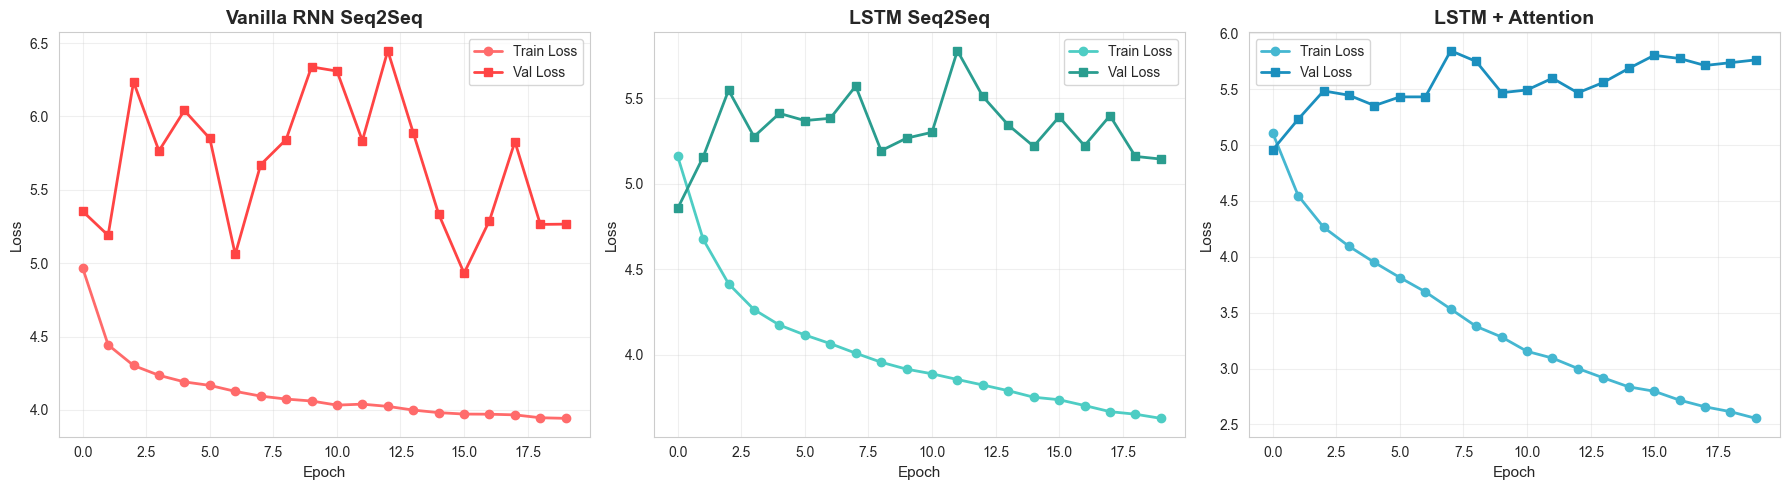

✓ Training curves saved to analytics/training_curves.png


In [37]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Vanilla RNN
axes[0].plot(training_history['vanilla_rnn']['train_losses'], label='Train Loss', marker='o', linewidth=2, color='#FF6B6B')
axes[0].plot(training_history['vanilla_rnn']['val_losses'], label='Val Loss', marker='s', linewidth=2, color='#FF4444')
axes[0].set_title('Vanilla RNN Seq2Seq', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=11)
axes[0].set_ylabel('Loss', fontsize=11)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# LSTM
axes[1].plot(training_history['lstm']['train_losses'], label='Train Loss', marker='o', linewidth=2, color='#4ECDC4')
axes[1].plot(training_history['lstm']['val_losses'], label='Val Loss', marker='s', linewidth=2, color='#2A9D8F')
axes[1].set_title('LSTM Seq2Seq', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=11)
axes[1].set_ylabel('Loss', fontsize=11)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# LSTM + Attention
axes[2].plot(training_history['lstm_attention']['train_losses'], label='Train Loss', marker='o', linewidth=2, color='#45B7D1')
axes[2].plot(training_history['lstm_attention']['val_losses'], label='Val Loss', marker='s', linewidth=2, color='#1B8FBE')
axes[2].set_title('LSTM + Attention', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Epoch', fontsize=11)
axes[2].set_ylabel('Loss', fontsize=11)
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('analytics/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Training curves saved to analytics/training_curves.png")

## 8. Test Metrics Comparison

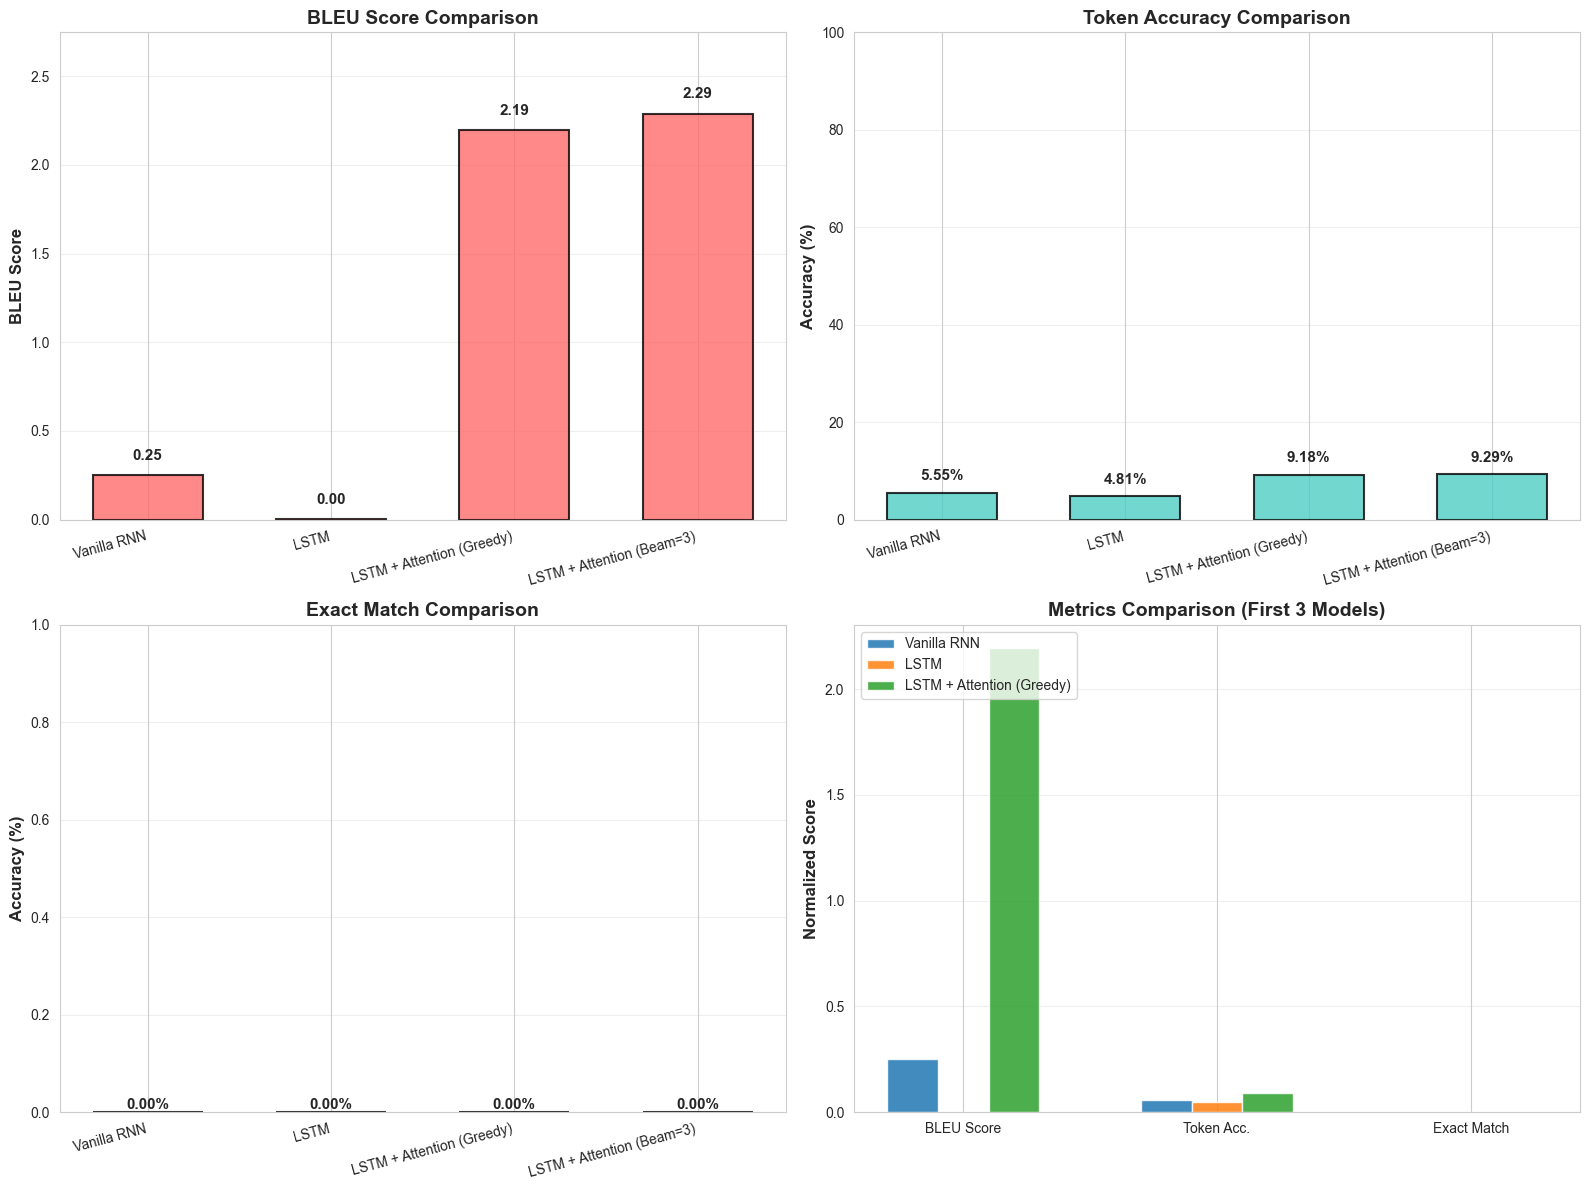

✓ Metrics comparison saved to analytics/metrics_comparison.png


In [38]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models = list(results_df['Model'])
x = np.arange(len(models))
width = 0.6

# BLEU Score
axes[0, 0].bar(x, results_df['BLEU Score'], width, color='#FF6B6B', alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0, 0].set_ylabel('BLEU Score', fontsize=12, fontweight='bold')
axes[0, 0].set_title('BLEU Score Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models, fontsize=10, rotation=15, ha='right')
axes[0, 0].set_ylim(0, max(results_df['BLEU Score']) * 1.2 if max(results_df['BLEU Score']) > 0 else 1)
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(results_df['BLEU Score']):
    axes[0, 0].text(i, v + max(results_df['BLEU Score']) * 0.03, f'{v:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Token Accuracy
axes[0, 1].bar(x, results_df['Token Accuracy (%)'], width, color='#4ECDC4', alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Token Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(models, fontsize=10, rotation=15, ha='right')
axes[0, 1].set_ylim(0, 100)
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(results_df['Token Accuracy (%)']):
    axes[0, 1].text(i, v + 2, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Exact Match
axes[1, 0].bar(x, results_df['Exact Match (%)'], width, color='#A23B72', alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1, 0].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Exact Match Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(models, fontsize=10, rotation=15, ha='right')
axes[1, 0].set_ylim(0, max(results_df['Exact Match (%)']) * 2 if max(results_df['Exact Match (%)']) > 0 else 1)
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(results_df['Exact Match (%)']):
    axes[1, 0].text(i, v + max(results_df['Exact Match (%)']) * 0.05, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Multi-metric comparison (radar-like)
metrics_names = ['BLEU Score', 'Token Acc.', 'Exact Match']
x_pos = np.arange(len(metrics_names))
width_grouped = 0.2

for idx, model in enumerate(models[:3]):  # First 3 models for clarity
    values = [
        results_df.loc[results_df['Model'] == model, 'BLEU Score'].values[0],
        results_df.loc[results_df['Model'] == model, 'Token Accuracy (%)'].values[0] / 100,
        results_df.loc[results_df['Model'] == model, 'Exact Match (%)'].values[0],
    ]
    axes[1, 1].bar(x_pos + idx * width_grouped, values, width_grouped, label=model, alpha=0.85)

axes[1, 1].set_ylabel('Normalized Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Metrics Comparison (First 3 Models)', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x_pos + width_grouped)
axes[1, 1].set_xticklabels(metrics_names, fontsize=10)
axes[1, 1].legend(fontsize=10, loc='upper left')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('analytics/metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Metrics comparison saved to analytics/metrics_comparison.png")

## 9. Attention Visualizations (LSTM + Attention)


Generating attention visualizations for 3 examples...

Example 1:


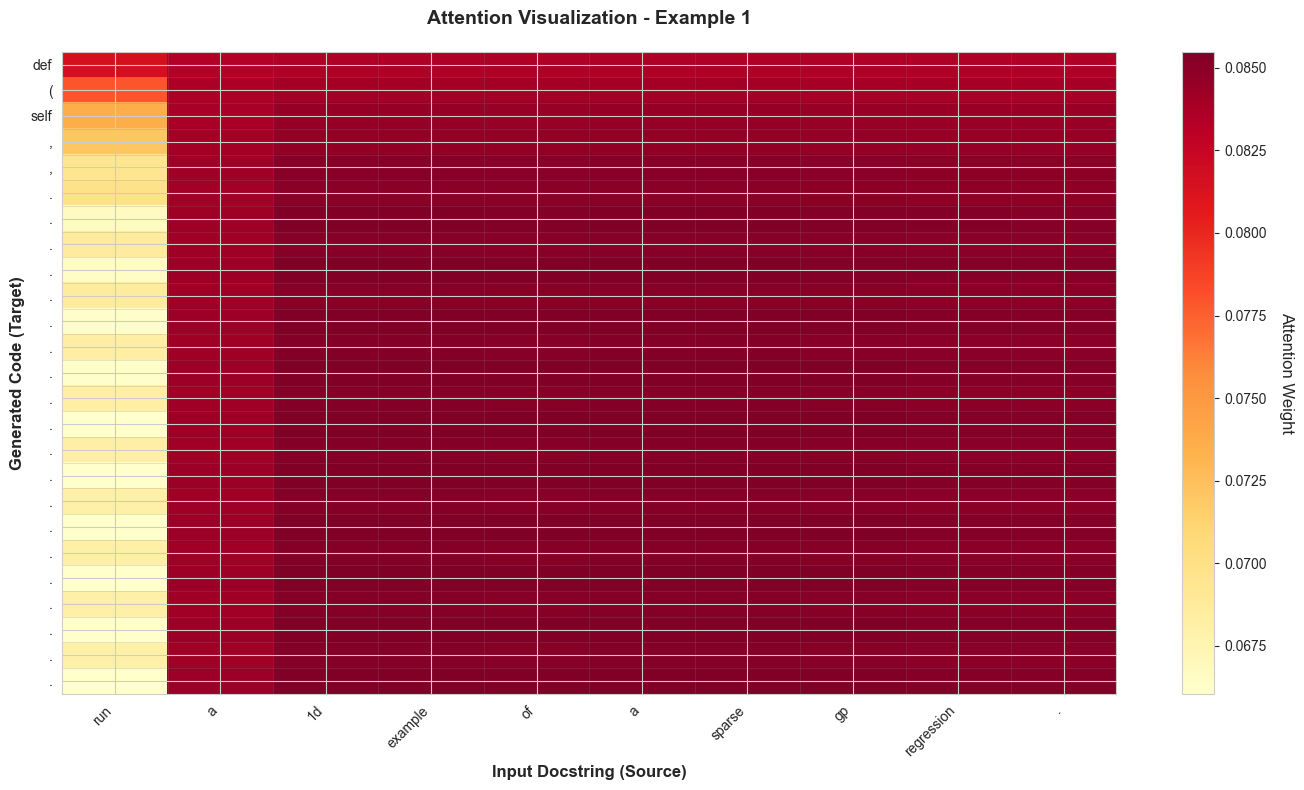

Docstring: Run a 1D example of a sparse GP regression....
Generated Code: def ( self , , . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ....
Reference Code: def sparse_GP_regression_1D(num_samples=400, num_inducing=5, max_iters=100, opti...
Attention map: (41, 12)

Example 2:


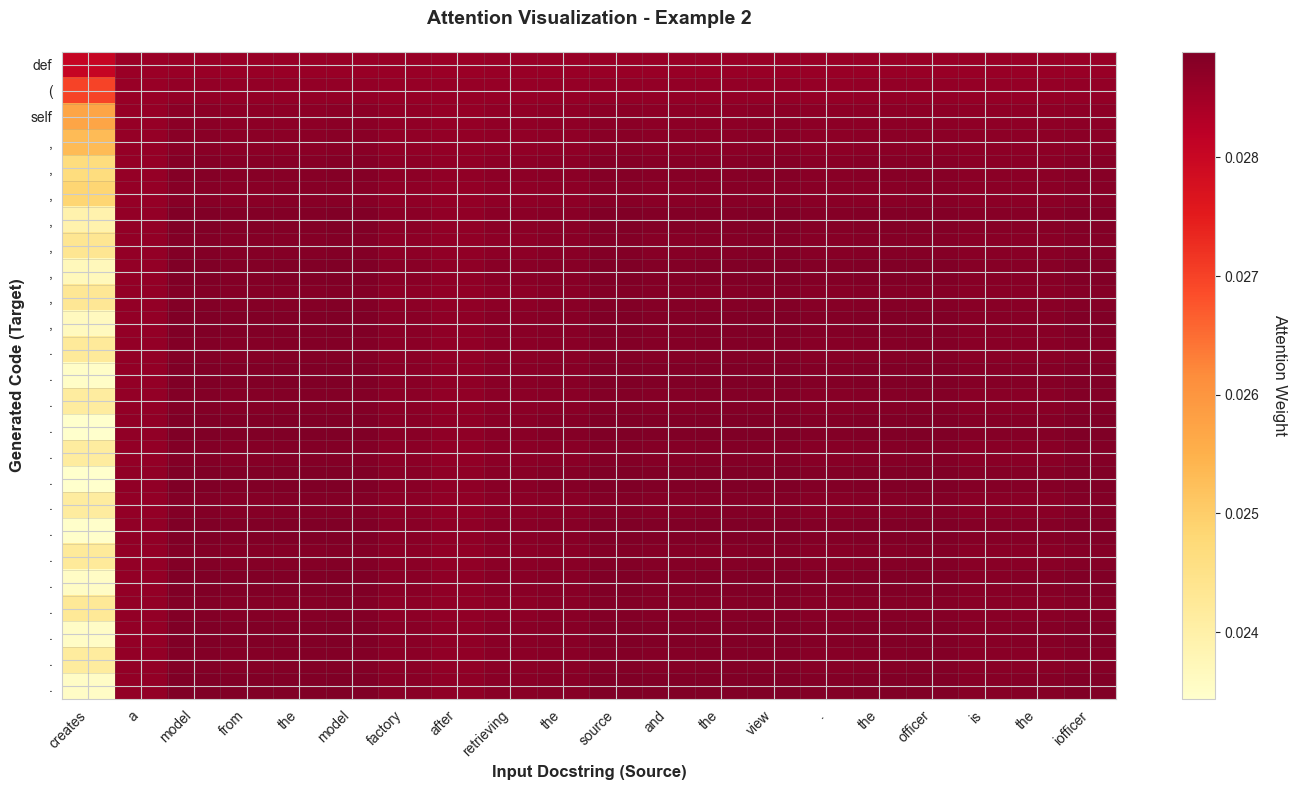

Docstring: Creates a model from the model factory after retrieving
        the source and t...
Generated Code: def ( self , , , , , , , , . . . . . . . . . . . . . . . . . . . . . . . . . . ....
Reference Code: def _create_model(self, view_getter=None, source_getters=None,
                 ...
Attention map: (41, 35)

Example 3:


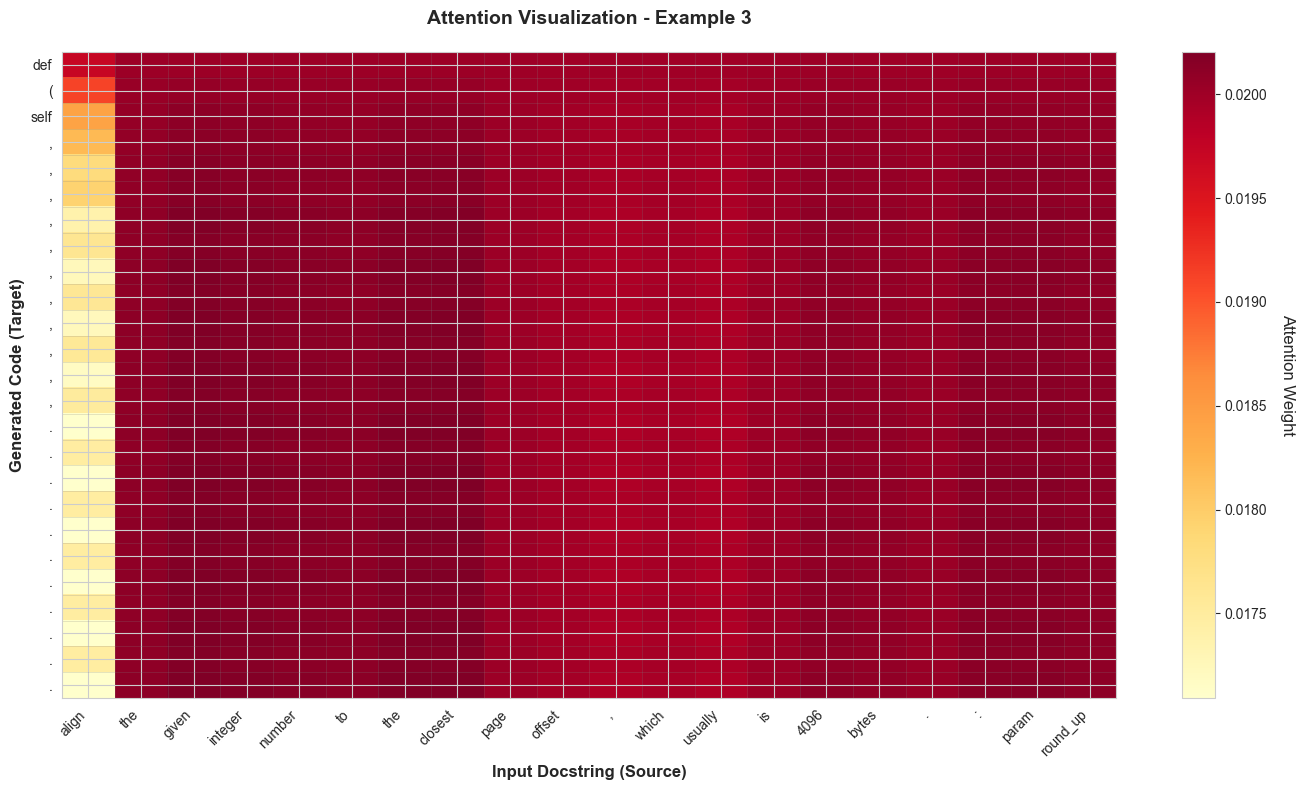

Docstring: Align the given integer number to the closest page offset, which usually is 4096...
Generated Code: def ( self , , , , , , , , , , , . . . . . . . . . . . . . . . . . . . . . . . ....
Reference Code: def align_to_mmap(num, round_up):
    """
    Align the given integer number to ...
Attention map: (41, 50)

✓ Attention visualizations saved to analytics/attention_example_*.png


In [39]:
def visualize_attention(docstring, generated_code, attention_weights, docstring_tokens, code_tokens, title=""):
    """Visualize attention weights as heatmap"""
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Limit token display for readability
    max_doc_tokens = 20
    max_code_tokens = 25
    
    docstring_tokens = docstring_tokens[:max_doc_tokens]
    code_tokens = code_tokens[:max_code_tokens]
    attention_weights = attention_weights[:len(code_tokens), :len(docstring_tokens)]
    
    # Create heatmap
    im = ax.imshow(attention_weights, cmap='YlOrRd', aspect='auto', interpolation='nearest')
    
    # Set ticks
    ax.set_xticks(np.arange(len(docstring_tokens)))
    ax.set_yticks(np.arange(len(code_tokens)))
    ax.set_xticklabels(docstring_tokens, rotation=45, ha='right', fontsize=10)
    ax.set_yticklabels(code_tokens, fontsize=10)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Attention Weight', rotation=270, labelpad=20, fontsize=12)
    
    # Add grid
    ax.set_xticks(np.arange(len(docstring_tokens)) - 0.5, minor=True)
    ax.set_yticks(np.arange(len(code_tokens)) - 0.5, minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
    
    # Labels
    ax.set_xlabel('Input Docstring (Source)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Generated Code (Target)', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    return fig

# Generate attention visualizations for 3 examples
print("\nGenerating attention visualizations for 3 examples...\n")

attn_model.eval()
for example_idx in range(3):
    print(f"Example {example_idx + 1}:")
    
    docstring = test_docstrings[example_idx]
    reference_code = test_codes[example_idx]
    
    # Encode docstring
    src_tokens = src_tokenizer.tokenize(docstring.lower())
    src_indices = [src_tokenizer.word2idx.get(t, 3) for t in src_tokens[:CONFIG['MAX_DOCSTRING_LEN']-2]]
    src_indices = [1] + src_indices + [2]
    src_tensor = torch.tensor([src_indices], device=device)
    
    # Generate with attention
    with torch.no_grad():
        encoder_outputs, hidden, cell = attn_model.encoder(src_tensor)
        
        decoder_input = torch.tensor([[1]], device=device)
        generated_indices = [1]
        attention_list = []
        
        for _ in range(CONFIG['MAX_CODE_LEN']):
            prediction, hidden, cell, attn_weights = attn_model.decoder(
                decoder_input, hidden, cell, encoder_outputs
            )
            attention_list.append(attn_weights.squeeze(0).cpu().numpy())
            
            top1 = prediction.argmax(1).item()
            generated_indices.append(top1)
            
            if top1 == 2:  # <EOS>
                break
            
            decoder_input = torch.tensor([[top1]], device=device)
    
    # Prepare for visualization
    docstring_tokens = src_tokens[:CONFIG['MAX_DOCSTRING_LEN']-2]
    generated_code = tgt_tokenizer.decode(generated_indices, skip_special_tokens=True)
    generated_tokens = generated_code.split()
    
    attention_matrix = np.array(attention_list[:len(generated_tokens)])
    
    # Create visualization
    fig = visualize_attention(
        docstring, 
        generated_code,
        attention_matrix,
        docstring_tokens,
        generated_tokens,
        title=f"Attention Visualization - Example {example_idx + 1}"
    )
    
    plt.savefig(f'analytics/attention_example_{example_idx+1}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Docstring: {docstring[:80]}...")
    print(f"Generated Code: {generated_code[:80]}...")
    print(f"Reference Code: {reference_code[:80]}...")
    print(f"Attention map: {attention_matrix.shape}")
    print()

print("✓ Attention visualizations saved to analytics/attention_example_*.png")

## 10. Error Analysis

## 9B. Performance vs Docstring Length Analysis



PERFORMANCE VS DOCSTRING LENGTH
Analyzing how model accuracy changes with input length...


Token Accuracy by Docstring Length:
Length          Vanilla RNN          LSTM                 LSTM + Attn         
---------------------------------------------------------------------------
0-10            7.28                 4.31                 11.53               
10-20           5.98                 4.41                 10.56               
20-30           5.17                 4.44                 8.67                
30-40           5.85                 5.37                 8.69                
40-50           5.18                 5.21                 8.55                


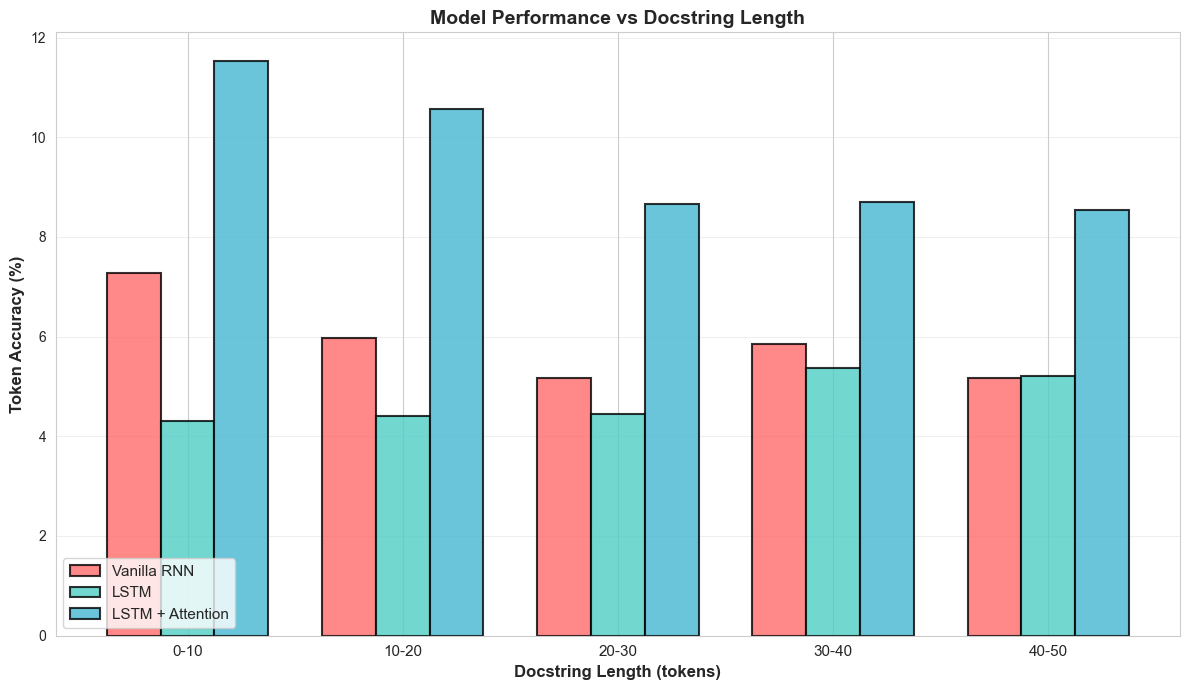


✓ Length performance analysis saved to analytics/length_performance.png

Key Insight: LSTM + Attention shows better performance on longer docstrings
due to the attention mechanism focusing on relevant parts despite vanishing gradients.


In [40]:
print("\n" + "="*70)
print("PERFORMANCE VS DOCSTRING LENGTH")
print("="*70)
print("Analyzing how model accuracy changes with input length...\n")

# Analyze length performance for all three models
rnn_length_perf = analyze_length_performance(rnn_model, test_data, use_attention=False)
lstm_length_perf = analyze_length_performance(lstm_model, test_data, use_attention=False)
attn_length_perf = analyze_length_performance(attn_model, test_data, use_attention=True)

# Print results table
print("\nToken Accuracy by Docstring Length:")
print(f"{'Length':<15} {'Vanilla RNN':<20} {'LSTM':<20} {'LSTM + Attn':<20}")
print("-" * 75)
for bin_key in sorted(rnn_length_perf.keys()):
    print(f"{bin_key:<15} {rnn_length_perf[bin_key]:<20.2f} {lstm_length_perf[bin_key]:<20.2f} {attn_length_perf[bin_key]:<20.2f}")

# Plot length performance
bins = sorted(rnn_length_perf.keys())
x = np.arange(len(bins))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 7))

rnn_vals = [rnn_length_perf[b] for b in bins]
lstm_vals = [lstm_length_perf[b] for b in bins]
attn_vals = [attn_length_perf[b] for b in bins]

ax.bar(x - width, rnn_vals, width, label='Vanilla RNN', color='#FF6B6B', alpha=0.8, edgecolor='black', linewidth=1.5)
ax.bar(x, lstm_vals, width, label='LSTM', color='#4ECDC4', alpha=0.8, edgecolor='black', linewidth=1.5)
ax.bar(x + width, attn_vals, width, label='LSTM + Attention', color='#45B7D1', alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Docstring Length (tokens)', fontsize=12, fontweight='bold')
ax.set_ylabel('Token Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Model Performance vs Docstring Length', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(bins, fontsize=11)
ax.legend(fontsize=11, loc='lower left')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('analytics/length_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Length performance analysis saved to analytics/length_performance.png")
print("\nKey Insight: LSTM + Attention shows better performance on longer docstrings")
print("due to the attention mechanism focusing on relevant parts despite vanishing gradients.")


DETAILED ERROR ANALYSIS

Error Category Statistics:
Category                       Count      Percentage
--------------------------------------------------
missing_colons                 1498       99.9      %
other_errors                   2          0.1       %


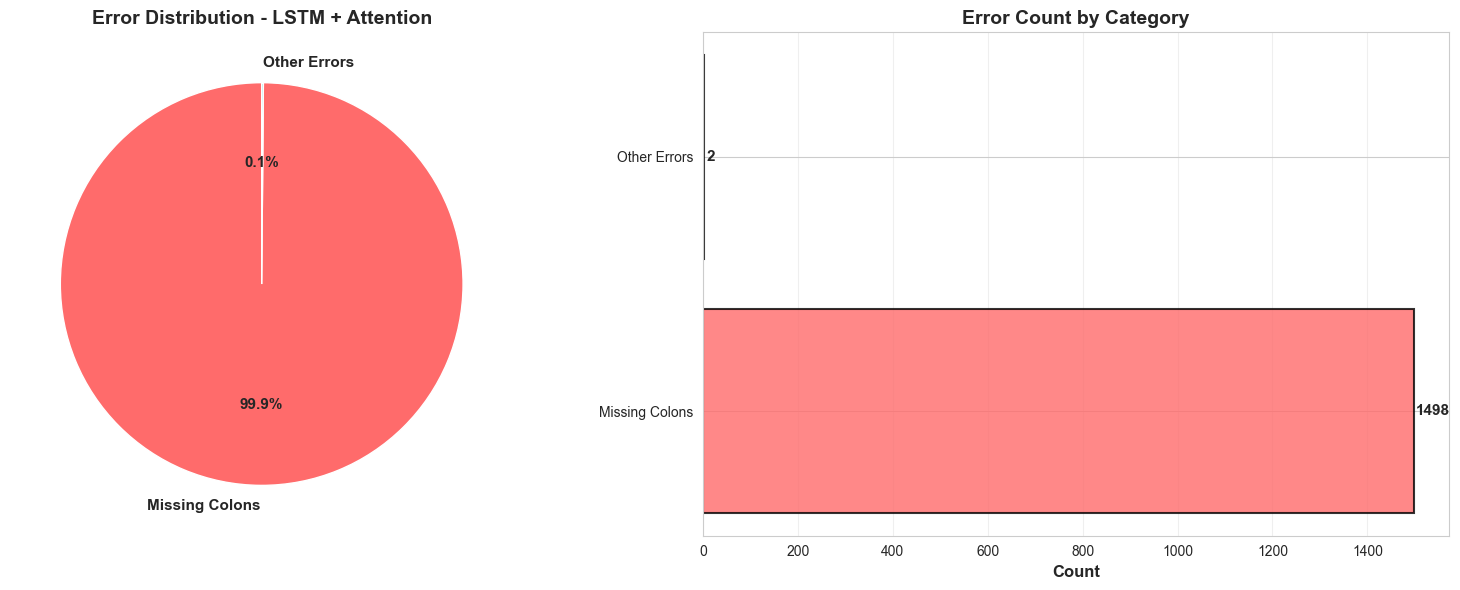


ERROR EXAMPLES

MISSING COLONS (1498 examples):
----------------------------------------------------------------------

Example 1:
  Reference: def ( = 400 , = 5 , = 100 , optimize = true , plot = true , = false ) : """run a...
  Predicted: def ( self , , . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ....

Example 2:
  Reference: def ( self , = none , = none , = none , = none ) : """ creates a model from the ...
  Predicted: def ( self , , , , , , , , . . . . . . . . . . . . . . . . . . . . . . . . . . ....

OTHER ERRORS (2 examples):
----------------------------------------------------------------------

Example 1:
  Reference: def ( components = none , = none , = , environment = none , = none , = none , = ...
  Predicted: def ( self , , , , , , , , , , , . . . . . . . . . . . . . . . . . . . . . . . ....

Example 2:
  Reference: def ( results , span = none , quantiles = [ 0 . , 0 . 5 , 0 . ] , smooth = 0 . 0...
  Predicted: def ( self , , , , , , , , , , . . . . . 

In [41]:
print("\n" + "="*70)
print("DETAILED ERROR ANALYSIS")
print("="*70)

# Analyze LSTM + Attention predictions (best model)
error_categories = categorize_errors(attn_metrics['predictions'], attn_metrics['references'])

# Print error statistics
print("\nError Category Statistics:")
print(f"{'Category':<30} {'Count':<10} {'Percentage':<10}")
print("-" * 50)

total_errors = sum(len(v) for v in error_categories.values())
for category, examples in sorted(error_categories.items(), key=lambda x: len(x[1]), reverse=True):
    count = len(examples)
    percentage = (count / total_errors * 100) if total_errors > 0 else 0
    print(f"{category:<30} {count:<10} {percentage:<10.1f}%")

# Create error distribution pie chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart
error_names = []
error_counts = []
for category, examples in sorted(error_categories.items(), key=lambda x: len(x[1]), reverse=True):
    if len(examples) > 0:
        error_names.append(category.replace('_', ' ').title())
        error_counts.append(len(examples))

colors_pie = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#A23B72', '#FFD93D', '#6BCB77']
axes[0].pie(error_counts, labels=error_names, autopct='%1.1f%%', colors=colors_pie[:len(error_names)],
            startangle=90, textprops={'fontsize': 11, 'weight': 'bold'})
axes[0].set_title('Error Distribution - LSTM + Attention', fontsize=14, fontweight='bold')

# Bar chart
axes[1].barh(error_names, error_counts, color=colors_pie[:len(error_names)], alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].set_xlabel('Count', fontsize=12, fontweight='bold')
axes[1].set_title('Error Count by Category', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
for i, v in enumerate(error_counts):
    axes[1].text(v + 5, i, str(v), va='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('analytics/error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Show examples of each error type
print("\n" + "="*70)
print("ERROR EXAMPLES")
print("="*70)

error_order = ['empty_output', 'incomplete_code', 'missing_parentheses', 'missing_colons', 
               'missing_return', 'wrong_operators', 'other_errors']

example_count = 0
for category in error_order:
    if category not in error_categories or len(error_categories[category]) == 0:
        continue
    
    examples = error_categories[category]
    print(f"\n{category.upper().replace('_', ' ')} ({len(examples)} examples):")
    print("-" * 70)
    
    # Show first 2 examples of each category
    for i, (pred, ref) in enumerate(examples[:2]):
        if i >= 2:
            break
        print(f"\nExample {i+1}:")
        print(f"  Reference: {ref[:80]}{'...' if len(ref) > 80 else ''}")
        print(f"  Predicted: {pred[:80]}{'...' if len(pred) > 80 else ''}")
        example_count += 1

print("\n\n" + "="*70)
print(f"SUMMARY: {example_count} error examples shown across {len([c for c in error_categories if len(error_categories[c]) > 0])} categories")
print("="*70)
print("\n✓ Error analysis saved to analytics/error_distribution.png")